In [145]:
from glob import glob
from math import sqrt

import tensorflow as tf
from tensorflow.python.keras.backend import set_session
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, Conv2DTranspose, Reshape, Flatten, Dense, BatchNormalization
from tensorflow.keras.models import Model, load_model
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

In [2]:
# Dataset preprocessing
# Only needs to be run once, Tyler ran it already

# DATA_DIR = "/hdd/datasets/UTKFace"
# image_paths = glob(DATA_DIR + "/*")

# images = np.zeros((len(image_paths), 96, 96, 3), dtype=np.float32)
# for i, image_path in enumerate(image_paths):
#     image = Image.open(image_path)
#     image = image.resize((96, 96), Image.LANCZOS)
#     images[i] = np.array(image) / 255.
# np.save("/hdd/datasets/UTKFace.npy", images)

In [3]:
# Loads numpy file containing dataset
images = np.load("/hdd/datasets/UTKFace.npy")

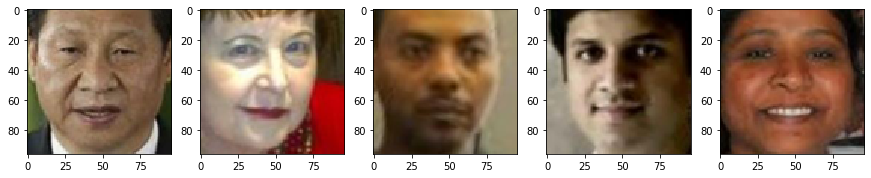

In [4]:
# Plots some sample images
fig, ax = plt.subplots(ncols=5, figsize=(15, 15))
for i, col in enumerate(ax):
    col.imshow(images[i])

In [5]:
def create_encoder(input_shape, encoding_dim):
    inputs = Input(shape=input_shape)
    conv1 = Conv2D(32, 3, padding="same", activation="relu")(inputs)
    conv1 = Conv2D(32, 3, padding="same", activation="relu")(conv1)
    norm1 = BatchNormalization()(conv1)
    pool1 = MaxPool2D()(norm1)
    
    conv2 = Conv2D(64, 3, padding="same", activation="relu")(pool1)
    conv2 = Conv2D(64, 3, padding="same", activation="relu")(conv2)
    norm2 = BatchNormalization()(conv2)
    pool2 = MaxPool2D()(norm2)
    
    conv3 = Conv2D(128, 3, padding="same", activation="relu")(pool2)
    conv3 = Conv2D(128, 3, padding="same", activation="relu")(conv3)
    norm3 = BatchNormalization()(conv3)
    pool3 = MaxPool2D()(norm3)
    
    encoder = Model(inputs, pool3)
    encoder.summary()
    
    return encoder

In [6]:
def create_decoder(encoding_dim):
    if not sqrt(encoding_dim).is_integer():
        raise ValueError("Encoding dim must be a perfect square.")
        
    inputs = Input(shape=(int(sqrt(encoding_dim)), int(sqrt(encoding_dim)), 128))
    conv1 = Conv2DTranspose(128, 3, strides=2, padding="same", activation="relu")(inputs)
    conv2 = Conv2DTranspose(64, 3, strides=2, padding="same", activation="relu")(conv1)
    conv3 = Conv2DTranspose(32, 3, strides=2, padding="same", activation="relu")(conv2)
    conv4 = Conv2D(3, 3, padding="same", activation="sigmoid")(conv3)
    
    decoder = Model(inputs, conv4)
    decoder.summary()
    
    return decoder

In [40]:
input_shape = images[0].shape
ENCODING_DIM = 144

In [8]:
encoder = create_encoder(input_shape, ENCODING_DIM)
decoder = create_decoder(ENCODING_DIM)

inputs = Input(shape=input_shape)
encoded = encoder(inputs)
decoded = decoder(encoded)

autoencoder = Model(inputs, decoded)
autoencoder.summary()

autoencoder.compile(optimizer="adam", loss="mse")

W1104 18:47:59.988329 140465173325568 deprecation.py:506] From /opt/anaconda/miniconda3/envs/caispp-tensorflow/lib/python3.7/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 96, 96, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 96, 96, 32)        896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 96, 96, 32)        9248      
_________________________________________________________________
batch_normalization (BatchNo (None, 96, 96, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 48, 48, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 48, 48, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 48, 48, 64)        36928 

In [9]:
!mkdir -p models/ae
checkpointer = ModelCheckpoint("models/epoch{epoch}_loss{val_loss:.4f}.h5", save_best_only=True, verbose=1)
autoencoder.fit(images, images, batch_size=128, epochs=50 validation_split=0.2, callbacks=[checkpointer])

Train on 18966 samples, validate on 4742 samples
Epoch 1/100
18944/18966 [============================>.] - ETA: 0s - loss: 0.0079
Epoch 00001: val_loss improved from inf to 0.03312, saving model to models/epoch1_loss0.0331.h5
18966/18966 [==============================] - 22s 1ms/sample - loss: 0.0079 - val_loss: 0.0331
Epoch 2/100
18944/18966 [============================>.] - ETA: 0s - loss: 0.0029
Epoch 00002: val_loss improved from 0.03312 to 0.00806, saving model to models/epoch2_loss0.0081.h5
18966/18966 [==============================] - 19s 998us/sample - loss: 0.0029 - val_loss: 0.0081
Epoch 3/100
18944/18966 [============================>.] - ETA: 0s - loss: 0.0026
Epoch 00003: val_loss improved from 0.00806 to 0.00350, saving model to models/epoch3_loss0.0035.h5
18966/18966 [==============================] - 19s 1ms/sample - loss: 0.0026 - val_loss: 0.0035
Epoch 4/100
18944/18966 [============================>.] - ETA: 0s - loss: 0.0022
Epoch 00004: val_loss improved from 0

Epoch 33/100
18944/18966 [============================>.] - ETA: 0s - loss: 8.5775e-04
Epoch 00033: val_loss did not improve from 0.00074
18966/18966 [==============================] - 20s 1ms/sample - loss: 8.5786e-04 - val_loss: 0.0011
Epoch 34/100
18944/18966 [============================>.] - ETA: 0s - loss: 9.3562e-04
Epoch 00034: val_loss did not improve from 0.00074
18966/18966 [==============================] - 20s 1ms/sample - loss: 9.3599e-04 - val_loss: 9.1445e-04
Epoch 35/100
18944/18966 [============================>.] - ETA: 0s - loss: 8.7070e-04
Epoch 00035: val_loss did not improve from 0.00074
18966/18966 [==============================] - 20s 1ms/sample - loss: 8.7192e-04 - val_loss: 8.4977e-04
Epoch 36/100
18944/18966 [============================>.] - ETA: 0s - loss: 7.7069e-04
Epoch 00036: val_loss improved from 0.00074 to 0.00071, saving model to models/epoch36_loss0.0007.h5
18966/18966 [==============================] - 20s 1ms/sample - loss: 7.7062e-04 - val_los

KeyboardInterrupt: 

In [16]:
print(sorted(glob("models/*")))
autoencoder = load_model("models/epoch46_loss0.0006.h5")

['models/epoch11_loss0.0015.h5', 'models/epoch13_loss0.0013.h5', 'models/epoch15_loss0.0013.h5', 'models/epoch17_loss0.0012.h5', 'models/epoch19_loss0.0011.h5', 'models/epoch1_loss0.0331.h5', 'models/epoch1_loss0.0363.h5', 'models/epoch1_loss0.0558.h5', 'models/epoch21_loss0.0010.h5', 'models/epoch23_loss0.0009.h5', 'models/epoch24_loss0.0008.h5', 'models/epoch25_loss0.0008.h5', 'models/epoch2_loss0.0081.h5', 'models/epoch2_loss0.0124.h5', 'models/epoch2_loss0.0528.h5', 'models/epoch31_loss0.0007.h5', 'models/epoch36_loss0.0007.h5', 'models/epoch3_loss0.0035.h5', 'models/epoch3_loss0.0047.h5', 'models/epoch43_loss0.0006.h5', 'models/epoch46_loss0.0006.h5', 'models/epoch4_loss0.0034.h5', 'models/epoch5_loss0.0016.h5', 'models/epoch5_loss0.0036.h5', 'models/epoch6_loss0.0035.h5', 'models/epoch6_loss0.0464.h5', 'models/epoch7_loss0.0031.h5', 'models/epoch7_loss0.0230.h5', 'models/epoch8_loss0.0023.h5', 'models/epoch9_loss0.0172.h5']


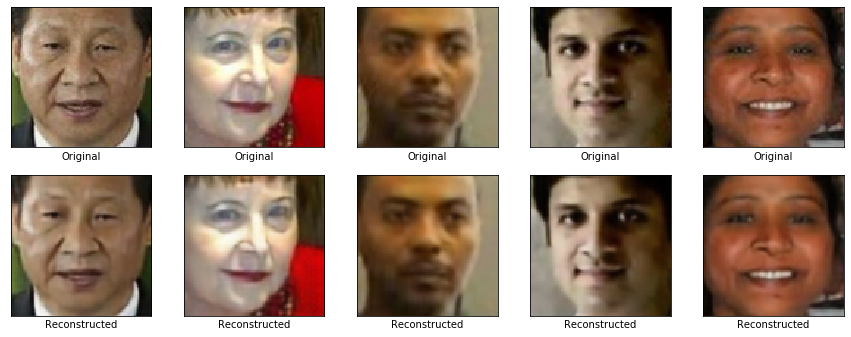

In [19]:
visual = images[:5]
preds = autoencoder(visual)

plt.figure(figsize=(15,15))
for i in range(5):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(visual[i])
    plt.xlabel("Original")
for i in range(5):
    plt.subplot(5,5,i+6)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(preds[i])
    plt.xlabel("Reconstructed")
plt.show()

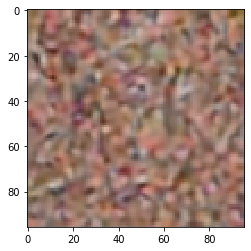

In [39]:
k = encoder(images[:1])
sample = k.std() * np.random.randn(1, 12, 12, 128) + k.mean()
test = decoder.predict(sample).squeeze()
plt.imshow(test)

In [165]:
ENCODING_DIM = 36

sess = tf.Session()
graph = tf.get_default_graph()
set_session(sess)

tfd = tfp.distributions
tfpl = tfp.layers
prior = tfd.Independent(tfd.Normal(loc=tf.zeros(ENCODING_DIM), scale=1), reinterpreted_batch_ndims=1)

In [166]:
def create_variational_encoder(input_shape, encoding_dim):
    inputs = Input(shape=input_shape)
    conv1 = Conv2D(32, 3, padding="same", activation="relu")(inputs)
    conv1 = Conv2D(32, 3, padding="same", activation="relu")(conv1)
    norm1 = BatchNormalization()(conv1)
    pool1 = MaxPool2D()(norm1)
    
    conv2 = Conv2D(64, 3, padding="same", activation="relu")(pool1)
    conv2 = Conv2D(64, 3, padding="same", activation="relu")(conv2)
    norm2 = BatchNormalization()(conv2)
    pool2 = MaxPool2D()(norm2)
    
    conv3 = Conv2D(128, 3, padding="same", activation="relu")(pool2)
    conv3 = Conv2D(128, 3, padding="same", activation="relu")(conv3)
    norm3 = BatchNormalization()(conv3)
    pool3 = MaxPool2D()(norm3)
    
    conv4 = Conv2D(256, 3, padding="same", activation="relu")(pool3)
    conv4 = Conv2D(256, 3, padding="same", activation="relu")(conv4)
    norm4 = BatchNormalization()(conv4)
    pool4 = MaxPool2D()(norm4)
    
    flatten = Flatten()(pool4)
    dense = Dense(tfpl.MultivariateNormalTriL.params_size(encoding_dim), activation=None)(flatten)
    reg = tfpl.MultivariateNormalTriL(encoding_dim, activity_regularizer=tfpl.KLDivergenceRegularizer(prior, weight=1.0))(dense)
    
    encoder = Model(inputs, reg)
    encoder.summary()
    
    return encoder

In [167]:
def create_variational_decoder(input_shape, encoding_dim):
    if not sqrt(encoding_dim).is_integer():
        raise ValueError("Encoding dim must be a perfect square.")
    dim = int(sqrt(encoding_dim))
        
    inputs = Input(encoding_dim)
    reshape = Reshape((dim, dim, 1))(inputs)
    conv1 = Conv2DTranspose(256, 3, strides=2, padding="same", activation="relu")(reshape)
    conv2 = Conv2DTranspose(128, 3, strides=2, padding="same", activation="relu")(conv1)
    conv3 = Conv2DTranspose(64, 3, strides=2, padding="same", activation="relu")(conv2)
    conv4 = Conv2DTranspose(32, 3, strides=2, padding="same", activation="relu")(conv3)
    conv5 = Conv2D(3, 3, padding="same", activation=None)(conv4)
    
    flatten = Flatten()(conv5)
    bernoulli = tfpl.IndependentBernoulli(input_shape, tfd.Bernoulli.logits)(flatten)
    
    decoder = Model(inputs, bernoulli)
    decoder.summary()
    
    return decoder

In [168]:
variational_encoder = create_variational_encoder(input_shape, ENCODING_DIM)
variational_decoder = create_variational_decoder(input_shape, ENCODING_DIM)

variational_inputs = Input(shape=input_shape)
variational_encoded = variational_encoder(variational_inputs)
variational_decoded = variational_decoder(variational_encoded)

variational_autoencoder = Model(variational_inputs, variational_decoded)
variational_autoencoder.summary()

Model: "model_48"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_75 (InputLayer)        [(None, 96, 96, 3)]       0         
_________________________________________________________________
conv2d_253 (Conv2D)          (None, 96, 96, 32)        896       
_________________________________________________________________
conv2d_254 (Conv2D)          (None, 96, 96, 32)        9248      
_________________________________________________________________
batch_normalization_118 (Bat (None, 96, 96, 32)        128       
_________________________________________________________________
max_pooling2d_118 (MaxPoolin (None, 48, 48, 32)        0         
_________________________________________________________________
conv2d_255 (Conv2D)          (None, 48, 48, 64)        18496     
_________________________________________________________________
conv2d_256 (Conv2D)          (None, 48, 48, 64)        369

In [170]:
negative_log_likelihood = lambda x, rv_x: -rv_x.log_prob(x)

variational_autoencoder.compile(optimizer="adam", loss=negative_log_likelihood)

In [171]:
!mkdir -p models/vae
checkpointer = ModelCheckpoint("models/vae/epoch{epoch}_loss{val_loss:.0f}.h5", save_best_only=True, verbose=1)
variational_autoencoder.fit(images, images, batch_size=128, epochs=50, validation_split=0.2, callbacks=[checkpointer])

Train on 18966 samples, validate on 4742 samples
Epoch 1/50
18944/18966 [============================>.] - ETA: 0s - loss: 1174.4266
Epoch 00001: val_loss improved from inf to 614.83461, saving model to models/vae/epoch1_loss615.h5
18966/18966 [==============================] - 30s 2ms/sample - loss: 1173.3128 - val_loss: 614.8346
Epoch 2/50
18944/18966 [============================>.] - ETA: 0s - loss: 124.3383
Epoch 00002: val_loss improved from 614.83461 to 438.08829, saving model to models/vae/epoch2_loss438.h5
18966/18966 [==============================] - 22s 1ms/sample - loss: 124.2329 - val_loss: 438.0883
Epoch 3/50
18944/18966 [============================>.] - ETA: 0s - loss: 41.2645
Epoch 00003: val_loss improved from 438.08829 to 188.28461, saving model to models/vae/epoch3_loss188.h5
18966/18966 [==============================] - 22s 1ms/sample - loss: 41.2633 - val_loss: 188.2846
Epoch 4/50
18944/18966 [============================>.] - ETA: 0s - loss: 43.4866
Epoch 00004

KeyboardInterrupt: 

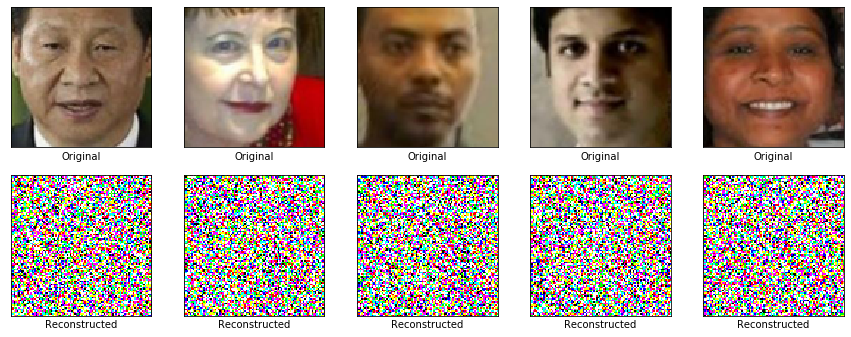

In [173]:
visual = images[:5]

with graph.as_default():
    preds = variational_autoencoder(visual).sample().eval(session=sess)

plt.figure(figsize=(15,15))
for i in range(5):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(visual[i])
    plt.xlabel("Original")
for i in range(5):
    plt.subplot(5,5,i+6)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(preds[i])
    plt.xlabel("Reconstructed")
plt.show()

In [181]:
with graph.as_default():
    k = variational_encoder(images[:1]).sample().eval(session=sess)
    sample = k.std() * np.random.randn(1, 36) + k.mean()
    test = variational_decoder(sample).sample().eval(session=sess).squeeze()
    plt.imshow(test)

TypeError: Input 'out_backprop' of 'Conv2DBackpropInput' Op has type float64 that does not match type float32 of argument 'filter'.